In [2]:
import cv2
import time
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

In [3]:
mp_manos= mp.solutions.hands

manos=mp_manos.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5)
manos_videos=mp_manos.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)

mp_dibujo= mp.solutions.drawing_utils

In [4]:
def detectarPuntosManos(imagen, mano, dibujo = True, display = True):
    
    if imagen is None:
        return
    imagen_salida=imagen.copy()

    imgRGB= cv2.cvtColor(imagen,cv2.COLOR_BGR2RGB)

    results=mano.process(imgRGB)

    if results.multi_hand_landmarks and dibujo:

        for hand_landmarks in results.multi_hand_landmarks:
            
            mp_dibujo.draw_landmarks(imagen_salida, landmark_list= hand_landmarks,
                                    connections= mp_manos.HAND_CONNECTIONS,
                                    landmark_drawing_spec=mp_dibujo.DrawingSpec(color=(255,255,255),
                                                                                thickness=2, circle_radius=2),
                                    connection_drawing_spec=mp_dibujo.DrawingSpec(color=(0,255,0),
                                                                                thickness=2, circle_radius=2))

    if display:

        plt.figure(figsize=[15,15])
        plt.subplot(121);plt.imshow(imagen[:,:,::-1]);plt.title("Imagen Original");plt.axis('off');
        plt.subplot(122);plt.imshow(imagen_salida[:,:,::-1]);plt.title("Salida");plt.axis('off');
    else:
        return imagen_salida, results

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


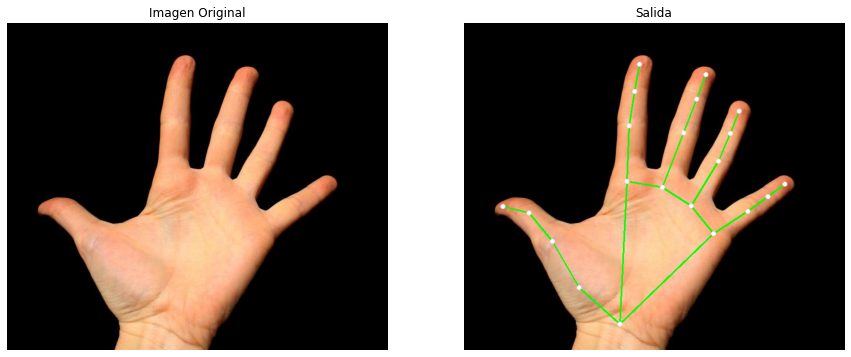

In [5]:
imagen =cv2.imread('media/prueba.jpg')
detectarPuntosManos(imagen, manos, display=True)


In [6]:
def contarDedos(imagen, results, dibujo=True, display=True):
    altura, ancho, _ =imagen.shape
    if imagen is None:
        return
    imagen_salida=imagen.copy()
    count={'RIGHT':0, 'LEFT':0}
    punta_dedos_ids=[mp_manos.HandLandmark.INDEX_FINGER_TIP, mp_manos.HandLandmark.MIDDLE_FINGER_TIP,
                    mp_manos.HandLandmark.RING_FINGER_TIP, mp_manos.HandLandmark.PINKY_TIP]
    
    estado_dedos={'PULGAR_DERECHO': False, 'INDICE_DERECHO': False, 'MEDIO_DERECHO': False, 'ANULAR_DERECHO': False,
                'MENIQUE_DERCHO': False, 'PULGAR_IZQUIERDO': False, 'INDICE_IZQUIERDO': False, 'MEDIO_IZQUIERDO': False, 
                'ANULAR_IZQUIERDO': False, 'MENIQUE_IZQUIERDO': False}
    
    for index_mano, mano_info in enumerate(results.multi_handedness):

        etiqueta_mano=mano_info.classification[0].label
        etiqueta_marcas=results.multi_hand_landmarks[index_mano]

        for punta_indice in punta_dedos_ids:

            nombre_dedo= punta_indice.name.split("_")[0]

            if(etiqueta_marcas.landmark[punta_indice].y < etiqueta_marcas.landmark[punta_indice -2].y):

                estado_dedos[etiqueta_mano.upper()+"_"+nombre_dedo]=True

                count[etiqueta_mano.upper()]+=1
            
        pulgar_punta_x=etiqueta_marcas.landmark[mp_manos.HandLandmark.THUMB_TIP].x
        pulgar_mcp_x=etiqueta_marcas.landmark[mp_manos.HandLandmark.THUMB_TIP -2].x

        if(etiqueta_mano=='Right' and (pulgar_punta_x < pulgar_mcp_x)) or (etiqueta_mano=='Left' and (pulgar_punta_x > pulgar_mcp_x)):
            estado_dedos[etiqueta_mano.upper()+"_THUMB"]=True
            count[etiqueta_mano.upper()]+= 1

    if dibujo:
        cv2.putText(imagen_salida, "Dedos totales: ", (10,25), cv2.FONT_HERSHEY_COMPLEX, 1,(20,255,255),2)
        cv2.putText(imagen_salida, str(sum(count.values())), (ancho//2-150,240), cv2.FONT_HERSHEY_SIMPLEX,8.9, (20,255,155),10,10)

    if display:
        plt.figure(figsize=[10,10])
        plt.imshow(imagen_salida[:,:,::-1]);plt.title("Imagen  salida");plt.axis('off');
    else:
        return imagen_salida, estado_dedos,count

In [7]:
camera_video=cv2.VideoCapture(0)
camera_video.set(3,1280)
camera_video.set(4,960)

cv2.namedWindow('Fingers Counter', cv2.WINDOW_NORMAL)

while camera_video.isOpened():
    ok, frame=camera_video.read()
    if not ok:
        continue
    frame=cv2.flip(frame,1)
    frame, results= detectarPuntosManos(frame, manos_videos, display=False)
    if results.multi_hand_landmarks:
        frame, estado_dedos, count= contarDedos(frame, results, display=False)
    
    cv2.imshow('Fingers Counter', frame)

    k=cv2.waitKey(1) & 0xFF

    if(k==27):
        break

camera_video.release()
cv2.destroyAllWindows()
